In [40]:
import torch
import torchvision
import torchvision.transforms.v2 as T
import torchvision.transforms.v2.functional as F
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
import numpy as np
import os
import json
import time
import random
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

## データの準備（Json書き換え）

In [2]:
# # jsonファイルをフォルダ構成に合うように修正
# # JSON ファイルのパス
# json_path = "data/annotations/train.json"

# # JSON を読み込む
# with open(json_path, "r") as f:
#     coco_data = json.load(f)

# # `file_name` を修正
# for img in coco_data["images"]:
#     img["file_name"] = os.path.basename(img["file_name"])  # `image/` を削除

# # 修正後の JSON を保存
# with open(json_path, "w") as f:
#     json.dump(coco_data, f, indent=4)

# print("JSON の修正が完了しました！")

In [3]:
# # jsonファイルをフォルダ構成に合うように修正
# # JSON ファイルのパス
# json_path = "data/annotations/val.json"

# # JSON を読み込む
# with open(json_path, "r") as f:
#     coco_data = json.load(f)

# # `file_name` を修正
# for img in coco_data["images"]:
#     img["file_name"] = os.path.basename(img["file_name"])  # `image/` を削除

# # 修正後の JSON を保存
# with open(json_path, "w") as f:
#     json.dump(coco_data, f, indent=4)

# print("JSON の修正が完了しました！")

In [44]:
# # JSON ファイルのパス
# json_path = "data/annotations/train.json"

# # JSON を読み込む
# with open(json_path, "r") as f:
#     coco_data = json.load(f)

In [48]:
# # カテゴリidを0から1に変更
# # torchでは0番は背景に使用される
# for cat in coco_data['categories']:
#     if cat['id'] == 0:
#         cat['id'] = 1

# # annotationsのcategory_idを0から1に変更
# for ann in coco_data['annotations']:
#     if ann['category_id'] == 0:
#         ann['category_id'] = 1

# # 保存
# with open(json_path, 'w') as f:
#     json.dump(coco_data, f, indent=4)

In [50]:
# # JSON ファイルのパス
# json_path = "data/annotations/val.json"

# # JSON を読み込む
# with open(json_path, "r") as f:
#     coco_data = json.load(f)

# # カテゴリidを0から1に変更
# # torchでは0番は背景に使用される
# for cat in coco_data['categories']:
#     if cat['id'] == 0:
#         cat['id'] = 1

# # annotationsのcategory_idを0から1に変更
# for ann in coco_data['annotations']:
#     if ann['category_id'] == 0:
#         ann['category_id'] = 1

# # 保存
# with open(json_path, 'w') as f:
#     json.dump(coco_data, f, indent=4)

In [ ]:
# #かくにん
# # # JSON を読み込む 
# with open(json_path, "r") as f: 
#     coco_data = json.load(f)
    
# for cat in coco_data['categories']: 
#     print(cat['id'])

## データセット、データローダ作成

In [132]:
class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, image_dir, annotation_dir):
        self.root = root
        self.image_dir = image_dir
        self.annotation_file = os.path.join(annotation_dir, f"{root}.json")
        self.coco = COCO(self.annotation_file)
        self.ids = list(self.coco.imgs.keys())

        # 画像変換（train はデータ拡張あり、val はなし）
        if root == "train":
            self.transforms = T.Compose([
                T.RandomHorizontalFlip(0.5),
                T.ColorJitter(brightness=2.0, contrast=0.5, saturation=0.2, hue=0.1),
                T.GaussianBlur(kernel_size=(3,3)),
                T.RandomErasing(p=0.3, scale=(0.02, 0.2)),
                T.ToImage(),
                T.ToDtype(torch.float32, scale=True)
            ])
        else:
            self.transforms = T.Compose([
                T.ToImage(),
                T.ToDtype(torch.float32, scale=True)
            ])

    def __getitem__(self, index):
        img_id = self.ids[index]
        img_info = self.coco.imgs[img_id]
        img_path = os.path.normpath(os.path.join(self.image_dir, img_info['file_name']))

        # 画像の読み込み
        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"⚠ 画像が見つかりません: {img_path}")
            return None  # エラー回避

        # アノテーション取得
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        boxes, labels, masks, areas, iscrowd = [], [], [], [], []

        for ann in annotations:
            x_min, y_min, width, height = ann["bbox"]
            if width > 0 and height > 0:  # 無効な bbox を除外
                x_max, y_max = x_min + width, y_min + height
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(ann["category_id"])
                masks.append(self.coco.annToMask(ann))
                areas.append(ann["area"])
                iscrowd.append(ann["iscrowd"])

        # すべての bbox が無効なら空のターゲットを返す
        if len(boxes) == 0:
            return None

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "masks": torch.tensor(np.array(masks), dtype=torch.uint8),
            "image_id": torch.tensor([img_id]),
            "area": torch.tensor(areas, dtype=torch.float32),
            "iscrowd": torch.tensor(iscrowd, dtype=torch.int64),
        }

        img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def collate_fn(batch):
        batch = list(filter(lambda x: x is not None, batch))
        return tuple(zip(*batch)) if batch else ([], [])  # 空データ対応


In [133]:
def evaluate(model, data_loader, device, threshold=0.3):
    """
    Mask R-CNN の bbox（バウンディングボックス）と segm（セグメンテーション）評価を行い、
    mAP, Precision, Recall を計算する。
    """
    model.eval()
    coco_gt = data_loader.dataset.coco  # Ground Truth (GT)
    coco_results_bbox = []  # bbox の評価用リスト
    coco_results_segm = []  # segm の評価用リスト

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for target, output in zip(targets, outputs):
                image_id = int(target["image_id"].item())

                # bbox の評価
                for box, score, label in zip(output["boxes"], output["scores"], output["labels"]):
                    if score < threshold:
                        continue
                    x_min, y_min, x_max, y_max = box.tolist()
                    width, height = x_max - x_min, y_max - y_min
                    coco_results_bbox.append({
                        "image_id": image_id,
                        "category_id": int(label.item()),
                        "bbox": [x_min, y_min, width, height],
                        "score": float(score.item())
                    })

                # segm の評価
                for mask, score, label in zip(output["masks"], output["scores"], output["labels"]):
                    if score < threshold:
                        continue
                    mask = mask[0].cpu().numpy()  # (1, H, W) → (H, W)
                    mask = (mask > 0.5).astype(np.uint8)  # バイナリマスク化
                    coco_results_segm.append({
                        "image_id": image_id,
                        "category_id": int(label.item()),
                        "segmentation": mask.tolist(),  # COCO は RLE (Run-Length Encoding) を期待する
                        "score": float(score.item())
                    })

    # bbox の評価
    if coco_results_bbox:
        coco_dt_bbox = coco_gt.loadRes(coco_results_bbox)
        coco_eval_bbox = COCOeval(coco_gt, coco_dt_bbox, "bbox")
        coco_eval_bbox.evaluate()
        coco_eval_bbox.accumulate()
        coco_eval_bbox.summarize()
        mAP_bbox = coco_eval_bbox.stats[0]
        precision_bbox = coco_eval_bbox.stats[1]  # Precision @ IoU=0.5
        recall_bbox = coco_eval_bbox.stats[8]  # Recall @ IoU=0.5:0.95
    else:
        mAP_bbox, precision_bbox, recall_bbox = 0, 0, 0

    # segm の評価
    if coco_results_segm:
        coco_dt_segm = coco_gt.loadRes(coco_results_segm)
        coco_eval_segm = COCOeval(coco_gt, coco_dt_segm, "segm")
        coco_eval_segm.evaluate()
        coco_eval_segm.accumulate()
        coco_eval_segm.summarize()
        mAP_segm = coco_eval_segm.stats[0]
        precision_segm = coco_eval_segm.stats[1]
        recall_segm = coco_eval_segm.stats[8]
    else:
        mAP_segm, precision_segm, recall_segm = 0, 0, 0

    return mAP_bbox, precision_bbox, recall_bbox, mAP_segm, precision_segm, recall_segm

## 訓練

In [134]:
def train(model, train_loader, val_loader, device, num_epochs=2, lr=0.005, output_dir="output"):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    os.makedirs(output_dir, exist_ok=True)
    csv_path = os.path.join(output_dir, "training_log.csv")

    log_data = {
        'epoch': [],
        'loss': [],
        'mAP_bbox': [],
        'precision_bbox': [],
        'recall_bbox': [],
        'mAP_segm': [],
        'precision_segm': [],
        'recall_segm': []
    }

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()
            losses.backward()
            optimizer.step()

        lr_scheduler.step()

        # bbox と segm の両方の評価を実行
        mAP_bbox, precision_bbox, recall_bbox, mAP_segm, precision_segm, recall_segm = evaluate(model, val_loader, device)

        print(f"Epoch {epoch+1}: Loss {epoch_loss:.4f}, mAP_bbox {mAP_bbox:.4f}, Precision_bbox {precision_bbox:.4f}, Recall_bbox {recall_bbox:.4f}, mAP_segm {mAP_segm:.4f}, Precision_segm {precision_segm:.4f}, Recall_segm {recall_segm:.4f}")

        log_data['epoch'].append(epoch+1)
        log_data['loss'].append(epoch_loss)
        log_data['mAP_bbox'].append(mAP_bbox)
        log_data['precision_bbox'].append(precision_bbox)
        log_data['recall_bbox'].append(recall_bbox)
        log_data['mAP_segm'].append(mAP_segm)
        log_data['precision_segm'].append(precision_segm)
        log_data['recall_segm'].append(recall_segm)

    log_df = pd.DataFrame(log_data)
    torch.save(model.state_dict(), os.path.join(output_dir, "model.pth"))
    log_df.to_csv(csv_path, index=False)

In [135]:
# 訓練画像データへのパス
image_dir = './data/images'
annotation_dir = './data/annotations'
batch_size = 16
num_epochs = 2

In [136]:
# 訓練用のデータセットを作成
train_dataset = CustomCocoDataset(root='train', image_dir=os.path.join(image_dir, 'train'), annotation_dir=annotation_dir)

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


In [137]:
# 訓練用のデータローダを作成
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)

In [138]:
# DataLoader から最初のバッチを取得
data_iter = iter(train_loader)
images, targets = next(data_iter)

# 画像の数とターゲットのキーを表示
print(f"バッチ内の画像数: {len(images)}")
print(f"ターゲットのキー: {targets[0].keys()}")

バッチ内の画像数: 16
ターゲットのキー: dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])


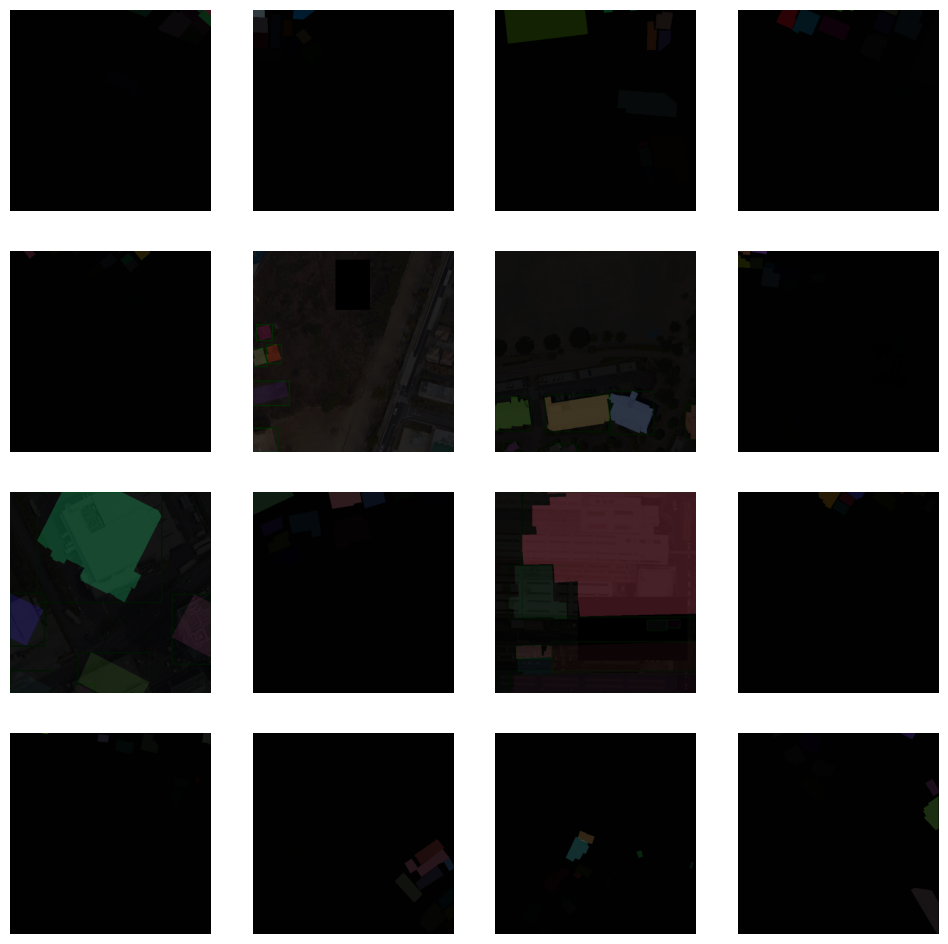

In [139]:
# 画像を描画
plt.figure(figsize=(12, 12))
num_images = min(len(images), 16)  # 最大16枚を表示

for i in range(num_images):
    img = images[i].permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)
    img = (img * 255).astype(np.uint8)  # 0-1 の範囲を 0-255 に変換
    H, W, _ = img.shape  # 画像の高さ・幅を取得

    # OpenCV で bbox を描画
    for box in targets[i]["boxes"]:
        x_min, y_min, x_max, y_max = map(int, box.tolist())
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # 緑色の枠

    # OpenCV でマスクを描画
    masks = targets[i]["masks"].cpu().numpy()  # (N, H, W)
    for mask in masks:
        mask = (mask > 0.5).astype(np.uint8)  # バイナリマスクに変換
        # mask_resized = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)  # 画像サイズにリサイズ

        color = [random.randint(0, 255) for _ in range(3)]  # ランダムな色
        mask_colored = np.zeros_like(img, dtype=np.uint8)
        mask_colored[:, :, 0] = mask * color[0]
        mask_colored[:, :, 1] = mask * color[1]
        mask_colored[:, :, 2] = mask * color[2]

        img = cv2.addWeighted(img, 0.7, mask_colored, 0.3, 0)  # 画像とマスクをブレンド

    # Matplotlib で描画
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(img)
    ax.axis("off")  # 軸を非表示

plt.show()

In [126]:
# 評価用のデータセットを作成
val_dataset = CustomCocoDataset(root='val', image_dir=os.path.join(image_dir, 'val'), annotation_dir=annotation_dir)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [127]:
# 評価用のデータローダを作成
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)

In [128]:
# DataLoader から最初のバッチを取得
data_iter = iter(val_loader)
images, targets = next(data_iter)

# 画像の数とターゲットのキーを表示
print(f"バッチ内の画像数: {len(images)}")
print(f"ターゲットのキー: {targets[0].keys()}")

バッチ内の画像数: 16
ターゲットのキー: dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])


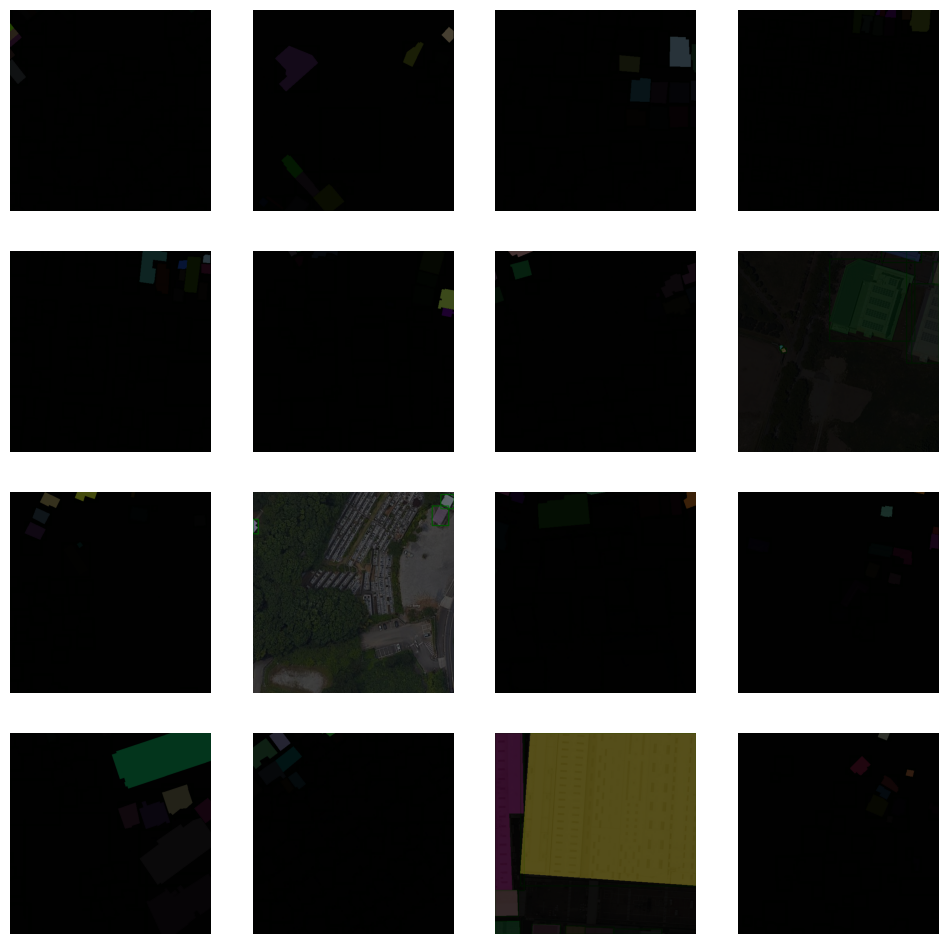

In [129]:
# 画像を描画
plt.figure(figsize=(12, 12))
num_images = min(len(images), 16)  # 最大16枚を表示

for i in range(num_images):
    img = images[i].permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)
    img = (img * 255).astype(np.uint8)  # 0-1 の範囲を 0-255 に変換
    H, W, _ = img.shape  # 画像の高さ・幅を取得

    # OpenCV で bbox を描画
    for box in targets[i]["boxes"]:
        x_min, y_min, x_max, y_max = map(int, box.tolist())
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # 緑色の枠

    # OpenCV でマスクを描画
    masks = targets[i]["masks"].cpu().numpy()  # (N, H, W)
    for mask in masks:
        mask = (mask > 0.5).astype(np.uint8)  # バイナリマスクに変換
        mask_resized = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)  # 画像サイズにリサイズ

        color = [random.randint(0, 255) for _ in range(3)]  # ランダムな色
        mask_colored = np.zeros_like(img, dtype=np.uint8)
        mask_colored[:, :, 0] = mask_resized * color[0]
        mask_colored[:, :, 1] = mask_resized * color[1]
        mask_colored[:, :, 2] = mask_resized * color[2]

        img = cv2.addWeighted(img, 0.7, mask_colored, 0.3, 0)  # 画像とマスクをブレンド

    # Matplotlib で描画
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(img)
    ax.axis("off")  # 軸を非表示

plt.show()

In [13]:
# デバイスの確認
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
# 訓練済みのmaskrcnnをロード
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)

In [15]:
# 一旦すべての層を訓練不可にする
for param in model.parameters():
    param.requires_grad = False

In [16]:
# クラス数を取得（背景クラス 0 を含むため +1）
num_classes = len(train_dataset.coco.cats) + 1

In [17]:
# 
# 訓練済みモデルの出力ヘッドをデータセットのクラス数に合わせて付け替える
# 
# box_predictorの置き換え
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features_box, num_classes)

In [18]:
# `mask_predictor` の置き換え
in_channels_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_channels_mask, 256, num_classes)

In [20]:
# モデルをcudaに渡す
model.to(device)
print(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [21]:
# 訓練の実行
train(model, train_loader, val_loader, device, num_epochs=num_epochs, lr=0.001, output_dir="output")

KeyboardInterrupt: 

## 推論

In [ ]:
# モデルのロード
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)
num_classes = 2

In [ ]:
# box_predictorの置き換え
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features_box, num_classes)

# `mask_predictor` の置き換え
in_channels_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_channels_mask, 256, num_classes)

In [ ]:
# 訓練済みモデルをロード
model.load_state_dict(torch.load("output/model.pth", map_location=device))
# モデルをGPUに送る
model.to(device)

In [ ]:
# 推論対象の画像
image_dir = "data/images/test"
image_list = os.listdir(image_dir)

In [ ]:
# 推論用の関数
def infer_images(model, image_dir, image_list, device, threshold=0.5, output_dir="output"):
    """
    訓練済みの Mask R-CNN モデルで複数の画像を推論し、結果を保存する

    Args:
        model: 訓練済みの PyTorch モデル
        image_dir: 画像のディレクトリ
        image_list: 推論する画像ファイルのリスト
        device: "cuda" または "cpu"
        threshold: バウンディングボックスを表示する信頼度の閾値
        output_dir: 推論結果の保存先ディレクトリ
    """
    model.to(device)
    model.eval()

    transform = T.Compose([
                T.ToImage(),  # 画像をPIL形式に変換
                T.ToDtype(torch.float32, scale=True)
                ]) 
    os.makedirs(output_dir, exist_ok=True)

    for image_file in image_list:
        image_path = os.path.join(image_dir, image_file)
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)  # (C, H, W) → (1, C, H, W)

        # 推論
        with torch.no_grad():
            output = model(image_tensor)[0]  # バッチの 0 番目を取得

        # 画像を NumPy 配列に変換（可視化用）
        image_np = np.array(image).astype(np.uint8)

        # バウンディングボックスとラベルを描画
        for i in range(len(output["boxes"])):
            score = output["scores"][i].item()
            if score < threshold:
                continue  # 信頼度が閾値未満ならスキップ

            box = output["boxes"][i].cpu().numpy().astype(int)
            label = output["labels"][i].item()
            mask = output["masks"][i, 0].cpu().numpy()

            # バウンディングボックスを描画
            cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
            cv2.putText(image_np, f"Label {label}: {score:.2f}", 
                        (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, (0, 255, 0), 2)

            # マスクを適用（しきい値 0.5 で二値化）
            mask_bin = (mask > 0.5).astype(np.uint8) * 255
            mask_bin = cv2.applyColorMap(mask_bin, cv2.COLORMAP_JET)
            image_np = cv2.addWeighted(image_np, 0.7, mask_bin, 0.3, 0)

        # 結果を保存
        output_path = os.path.join(output_dir, f"output_{image_file}")
        cv2.imwrite(output_path, cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))
        print(f"Saved: {output_path}")

        # 結果を表示
        plt.figure(figsize=(8, 6))
        plt.imshow(image_np)
        plt.axis("off")
        plt.show()

In [ ]:
# 推論の実行
infer_images(model, image_dir, image_list, device, threshold=0.5, output_dir="output_results")